In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

pd.set_option('display.max_colwidth',None)

In [3]:
users = pd.read_json('US_PoliticalTweets/users.json',lines=True,encoding='UTF-8')
tweets = pd.read_json('US_PoliticalTweets/tweets.json',lines=True,encoding='UTF-8')

In [4]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243370 entries, 0 to 1243369
Data columns (total 32 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   contributors               0 non-null        float64       
 1   coordinates                2734 non-null     object        
 2   created_at                 1243370 non-null  datetime64[ns]
 3   display_text_range         1243370 non-null  object        
 4   entities                   1243370 non-null  object        
 5   favorite_count             1243370 non-null  int64         
 6   favorited                  1243370 non-null  bool          
 7   geo                        2734 non-null     object        
 8   id                         1243370 non-null  int64         
 9   id_str                     1243370 non-null  int64         
 10  in_reply_to_screen_name    65411 non-null    object        
 11  in_reply_to_status_id      54146 non-

In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype              
---  ------                              --------------  -----              
 0   contributors_enabled                548 non-null    bool               
 1   created_at                          548 non-null    datetime64[ns, UTC]
 2   default_profile                     548 non-null    bool               
 3   default_profile_image               548 non-null    bool               
 4   description                         548 non-null    object             
 5   entities                            545 non-null    object             
 6   favourites_count                    548 non-null    int64              
 7   follow_request_sent                 548 non-null    bool               
 8   followers_count                     548 non-null    int64              
 9   following                           548 non

In [6]:
us = users.iloc[:,[13,1,20,4,8,19]]
tw = tweets.iloc[:,[8,24,2,5,18,22]]

In [7]:
df1 = tw[['user_id','created_at']].groupby('user_id').count()
df1.reset_index(inplace=True)
df1.rename({'created_at':'number of tweets'},axis=1,inplace=True)

df2 = pd.merge(df1,us,left_on='user_id',right_on='id')
df2 = df2.sort_values('followers_count',ascending=False)

df2.iloc[0,1] += df2.iloc[1,1]
df2.drop(index=542,inplace=True)

res = pearsonr(df2['number of tweets'],df2['followers_count'])
res

PearsonRResult(statistic=0.09382709823497484, pvalue=0.02865500131598293)

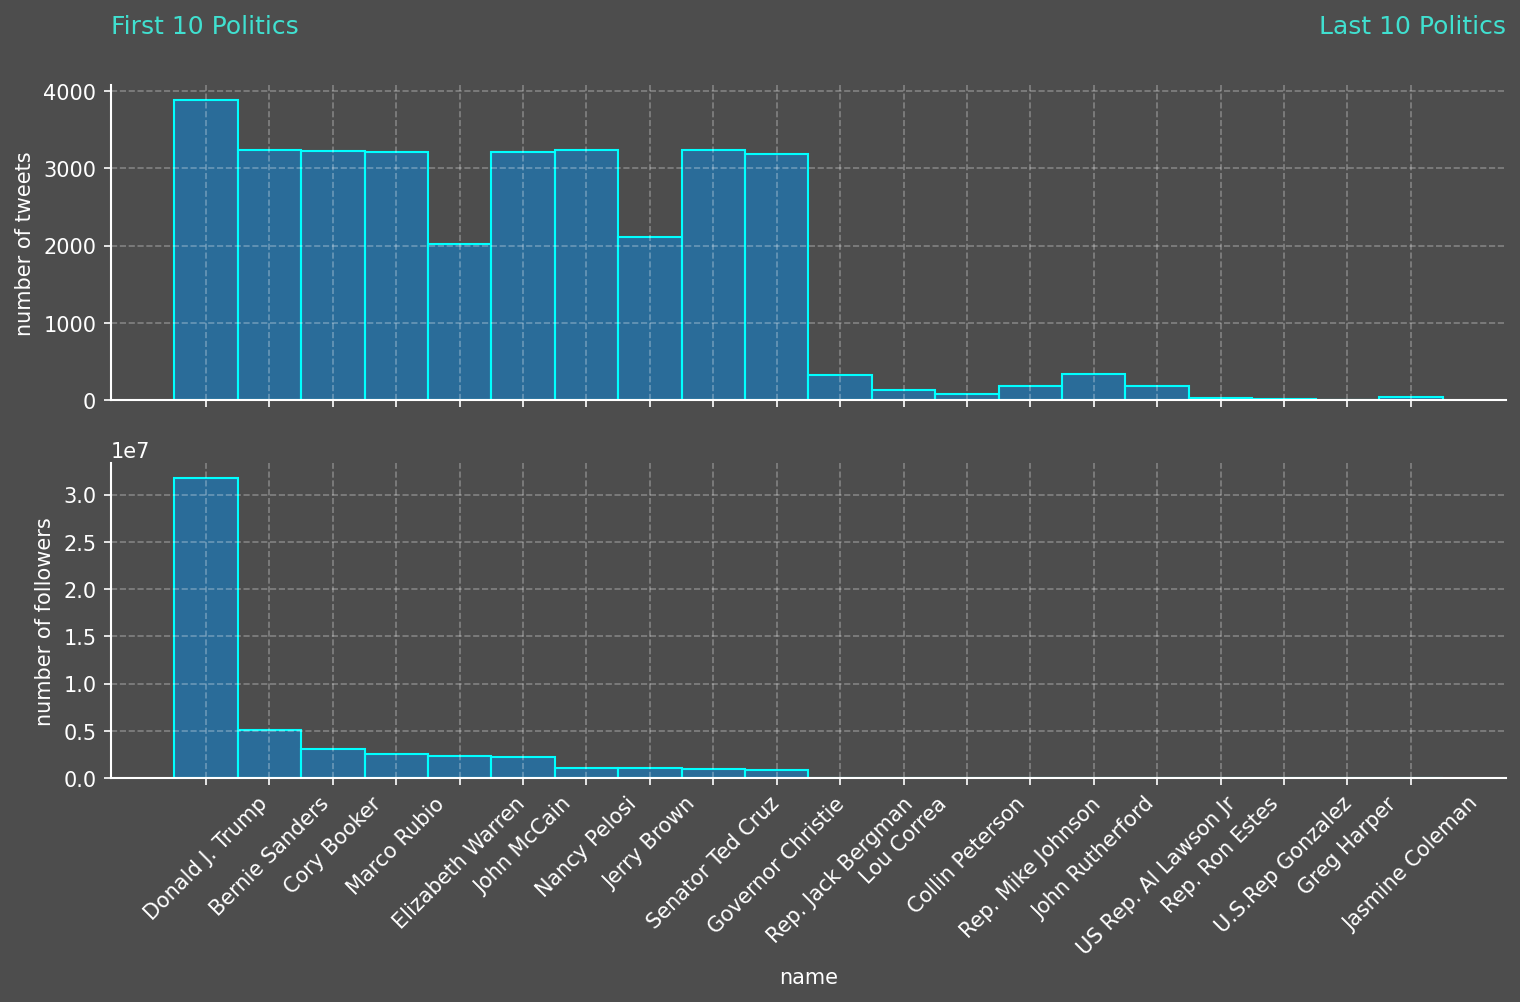

In [8]:
df2 = pd.concat([df2.head(10),df2.tail(10)])

plt.style.use("stylesheet.matplotlibrc")
fig, ax = plt.subplots(2,1,sharex=True)

sns.histplot(df2,x="name",weights="number of tweets",edgecolor='aqua',ax=ax[0])
ax[0].set_ylabel('number of tweets')

sns.histplot(df2,x="name",weights="followers_count",edgecolor='aqua',ax=ax[1])
ax[1].set_ylabel('number of followers')
plt.xticks(rotation=45)


ax[0].set_title("First 10 Politics",c='turquoise',loc='left',pad=25)
ax[0].set_title("Last 10 Politics",c='turquoise',loc='right',pad=25)
plt.show()

In [9]:
conn = sqlite3.connect('Lobbyists4America.db')
cur = conn.cursor()

In [10]:
cur.execute("""
CREATE TABLE Users
(
  id              INTEGER NOT NULL,
  created_at      TEXT    NULL    ,
  name            TEXT    NULL    ,
  description     TEXT    NULL    ,
  followers_count INTEGER NULL    ,
  location        TEXT    NULL    ,
  PRIMARY KEY (id)
);
""")
cur.execute("""
CREATE TABLE Tweets
(
  id             INTEGER NOT NULL,
  User_id        INTEGER NOT NULL,
  created_at     TEXT    NULL    ,
  favorite_count INTEGER NULL    ,
  retweet_count  INTEGER NULL    ,
  text           TEXT    NULL    ,
  PRIMARY KEY (id),
  FOREIGN KEY (User_id) REFERENCES Users (id)
);
""")

OperationalError: table Users already exists

In [ ]:
tw.to_sql('Tweets',conn,if_exists='append',index=False)
us.to_sql('Users',conn,if_exists='append',index=False)

548

In [ ]:
df3 = pd.read_sql("""
SELECT
    STRFTIME('%Y', created_at) AS Date,
    COUNT(*) AS `Number of Tweets`
FROM
    Tweets
GROUP BY
    Date
ORDER BY
    Date
""",conn)
df3

,Date,Number of Tweets
0,2008,112
1,2009,8234
2,2010,13763
3,2011,35163
4,2012,50791
5,2013,124439
6,2014,168308
7,2015,258256
8,2016,354942
9,2017,229362


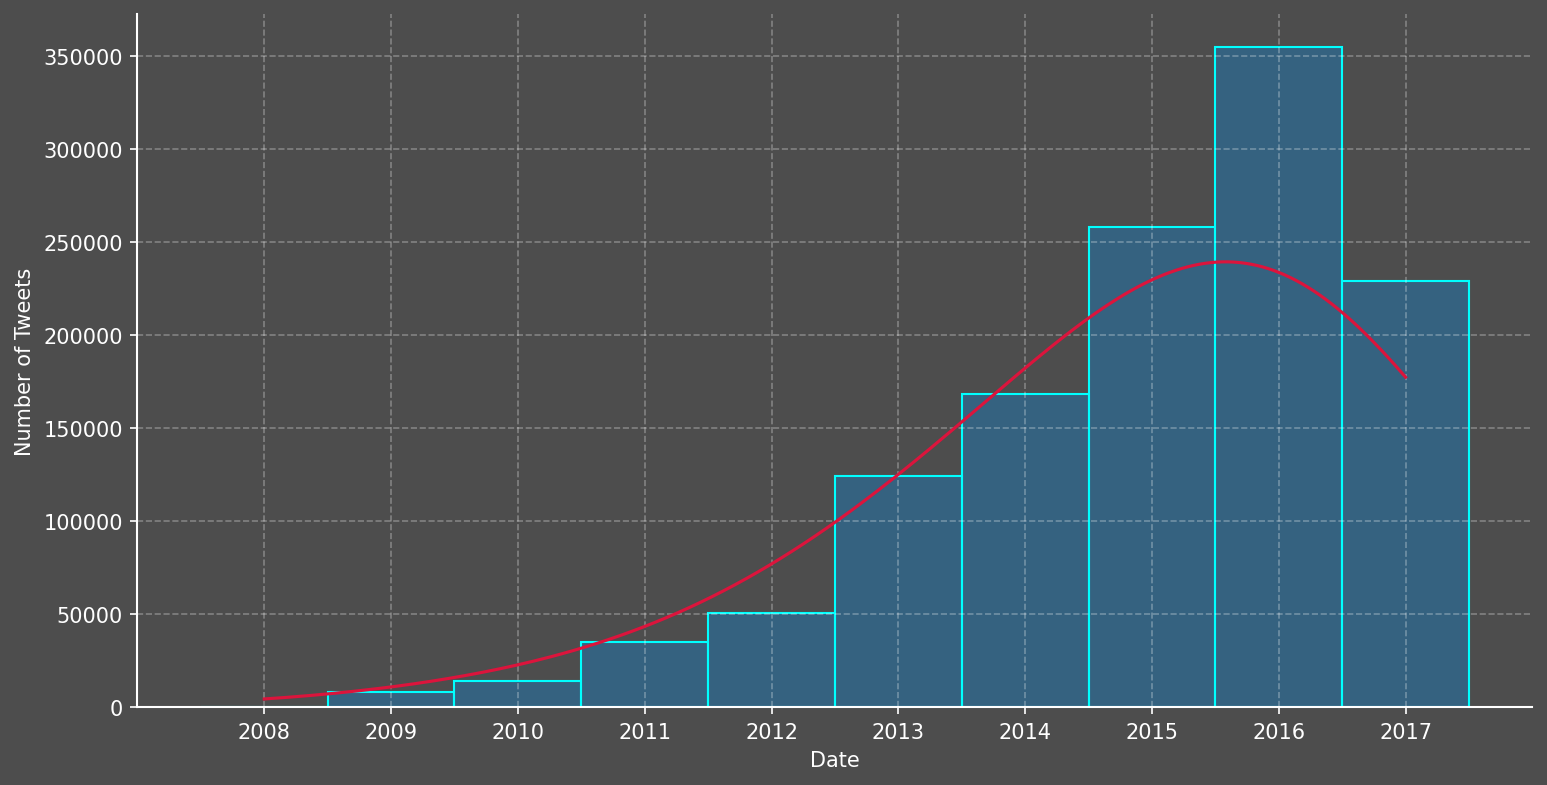

In [ ]:
ax = sns.histplot(df3,x='Date',weights='Number of Tweets',edgecolor='cyan',kde=True)
ax.lines[0].set_color('crimson')
ax.set_ylabel('Number of Tweets')
plt.show()

In [ ]:
dfl = pd.read_sql("""
SELECT
    text,
    favorite_count,
    created_at
FROM
    Tweets
GROUP BY
    text
ORDER BY
    favorite_count DESC
""",conn)
dfl.head(10)

,text,favorite_count,created_at
0,"President Trump, you made a big mistake. By trying to divide us up by race, religion, gender and nationality you actually brought us closer. https://t.co/U7deCCTFx9",984832,2017-01-21 22:15:24
1,Such a beautiful and important evening! The forgotten man and woman will never be forgotten again. We will all come together as never before,627475,2016-11-09 11:36:58
2,TODAY WE MAKE AMERICA GREAT AGAIN!,569283,2016-11-08 11:43:14
3,.@realDonaldTrump They did. It wasn't. https://t.co/xqt29RJPEr,527319,2017-02-25 13:56:12
4,"Peaceful protests are a hallmark of our democracy. Even if I don't always agree, I recognize the rights of people to express their views.",392346,2017-01-22 14:23:17
5,"Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don't know what to do. Love!",347262,2016-12-31 13:17:21
6,"Hey Republicans, don't worry, that burn is covered under the Affordable Care Act",315624,2017-03-24 19:53:43
7,"THANK YOU for another wonderful evening in Washington, D.C. TOGETHER, we will MAKE AMERICA GREAT AGAIN🇺🇸 https://t.co/V3aoj9RUh4",291081,2017-01-21 04:56:15
8,"How long did it take your staff of 823 people to think that up--and where are your 33,000 emails that you deleted? https://t.co/gECLNtQizQ",289727,2016-06-09 20:40:32
9,It all begins today! I will see you at 11:00 A.M. for the swearing-in. THE MOVEMENT CONTINUES - THE WORK BEGINS!,269437,2017-01-20 12:31:53


In [ ]:
dftop = pd.read_sql("""
SELECT
    text,
    STRFTIME('%Y',created_at) date,
    favorite_count,
    ROW_NUMBER () OVER ( 
        ORDER BY favorite_count 
    ) RowNum
FROM
    Tweets
GROUP BY
    text
ORDER BY
    favorite_count DESC
LIMIT 5000;
""",conn)
dfmid = pd.read_sql("""
SELECT
    *
FROM(
    SELECT
        text,
        STRFTIME('%Y',created_at) date,
        favorite_count,
        ROW_NUMBER () OVER ( 
            ORDER BY favorite_count DESC
        ) RowNum
    FROM
        Tweets
    GROUP BY
        text
    ORDER BY
        favorite_count DESC)
WHERE
    RowNum >= (SELECT COUNT(*)/2 FROM Tweets)
LIMIT 5000;
""",conn)
dfbot = pd.read_sql("""
SELECT
    text,
    STRFTIME('%Y',created_at) date,
    favorite_count,
    ROW_NUMBER () OVER ( 
        ORDER BY favorite_count 
    ) RowNum
FROM
    Tweets
GROUP BY
    text
ORDER BY
    favorite_count
LIMIT 5000;
""",conn)
df = pd.concat([dftop,dfmid,dfbot])
df

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler,MinMaxScaler
# from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score,mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import L2
from keras.losses import MeanSquaredError
from keras.optimizers.legacy import Adam

X = df.iloc[:,0].values
y = df.iloc[:,2].values
print(y)
X_train, X_, y_train, y_ = train_test_split(X,y,train_size=0.6,random_state=0)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.5,random_state=0)

vect = CountVectorizer(lowercase=False)
X_train_vect = vect.fit_transform(X_train).toarray()
X_cv_vect = vect.transform(X_cv)
X_test_vect = vect.transform(X_test)
print(y_test)

scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(np.array([y_train]).T)
y_cv_scaled = scaler.transform(np.array([y_cv]).T)
y_test_scaled = scaler.transform(np.array([y_test]).T)
y_train_scaled

In [ ]:
model = Sequential([
    Dense(25,'relu'),
    Dense(15,'relu',kernel_regularizer=L2()),
    Dense(5,'relu'),
    Dense(1)
])
model.compile(Adam(0.03),MeanSquaredError(),metrics=['mae'])
model.fit(X_train_vect,y_train_scaled,epochs=10)

In [ ]:
pred = model.predict(X_cv_vect)
print(mean_squared_error(y_cv_scaled,pred))

pred = model.predict(X_test_vect)
print(mean_squared_error(y_test_scaled,pred))

In [ ]:
def favorite_count_predictor(text):
    if type(text) == str:
        text = [text]
    text_vect = vect.transform(text)
    pred = model.predict(text_vect)
    result = scaler.inverse_transform(pred)
    return np.array(result.T)

print(y[:5])
print(X[:5])
favorite_count_predictor(X[:5])